In [7]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [8]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [9]:
df = pd.read_excel("Sample - Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [10]:
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

# Data Preprocessing

In [12]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [13]:
furniture.head()

,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [14]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
# furniture.index
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


# Average sales per month

In [15]:
y = furniture['Sales'].resample('MS').mean()
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

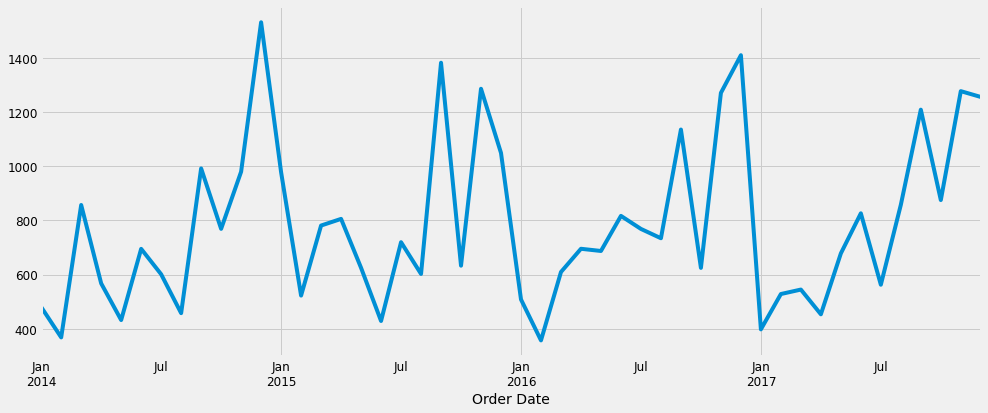

In [16]:
y.plot(figsize=(15, 6))
plt.show()

### Visualizing data using time-series decomposition that allows us to decompose our time series into three distinct components: 
* trend
* seasonality
* noise

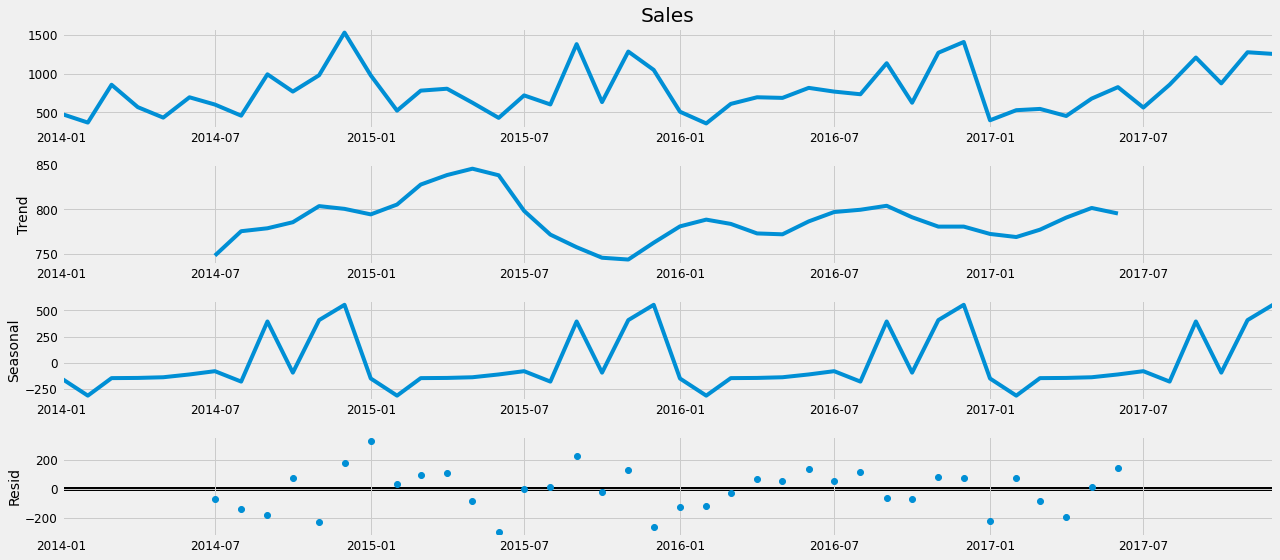

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# Forcasting using ARIMA (AutoRegressive Integrated Moving Average)

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


# Grid search to get best value for p, d, q

In [17]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1377.6737760934338
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130920218
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997936975
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.23144334183365


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1351.9870527777302
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.2488280302665
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758109


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2729.072618268503
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809163
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896732944


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.596169194252
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2596.5441486651466
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946867
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576429577
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1419.5229124116067
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.6378567198382
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:304.9671228167956


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1427.5538425319955
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:306.9113200151471
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817193
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3273.8903190805663
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482836
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.58062316810697
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.18329774425985
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2815.6702397164836
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417252
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.55766214612436
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1299.6923251853673
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:304.20776751609645
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935201
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1235.4410171865957
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084546
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.58426921438553
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.7794442186298
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2669.5950391144597
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.36851958150464


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.34221939659585
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876872
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2538.03381188337
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.0156002197207
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.7513188154284
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902


C:\Users\ra280\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1361.1057477374725
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.2003422281135
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:300.2130611619095
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.340365878503
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:4513145211.160381
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345417
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:302.32649925127873
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835535
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:8999.750822500157
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.4762687609949
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.3873006939403
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.525035466085
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2669.7116740937036
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439535705
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:283.3661017772306


ARIMA(1, 1, 1)x(1, 1, 0, 12) yields lowest AIC: 297.79

# Fitting ARIMA Model

In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


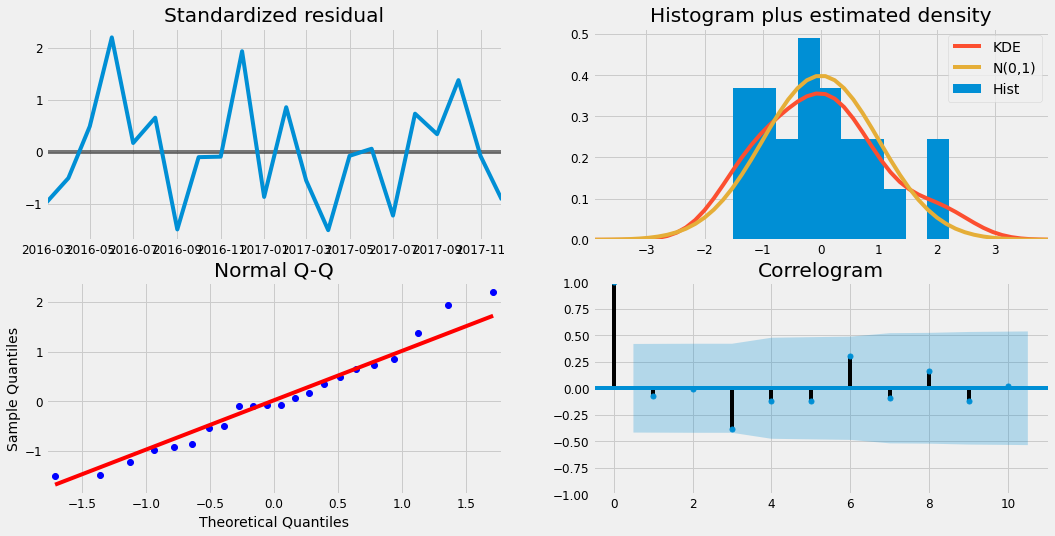

In [19]:
# Model diagnostics to check for any unusual behaviour
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Model validation

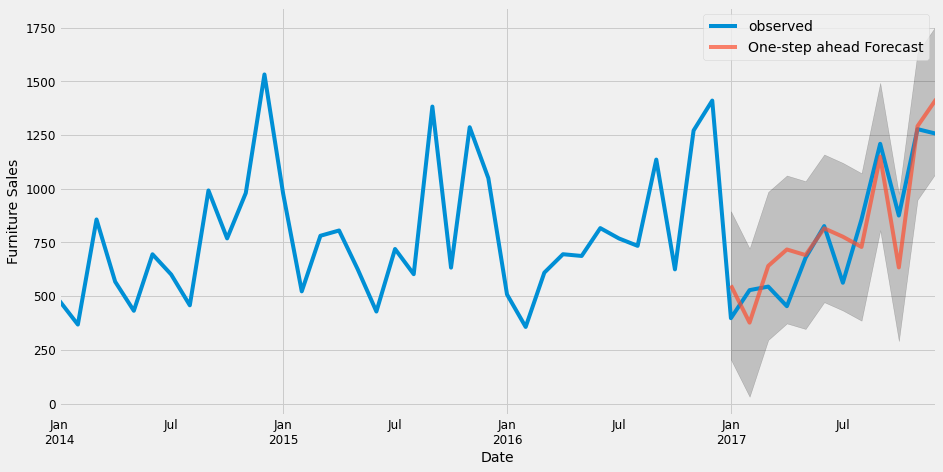

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [22]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 22993.57
The Root Mean Squared Error of our forecasts is 151.64


# Forecasts

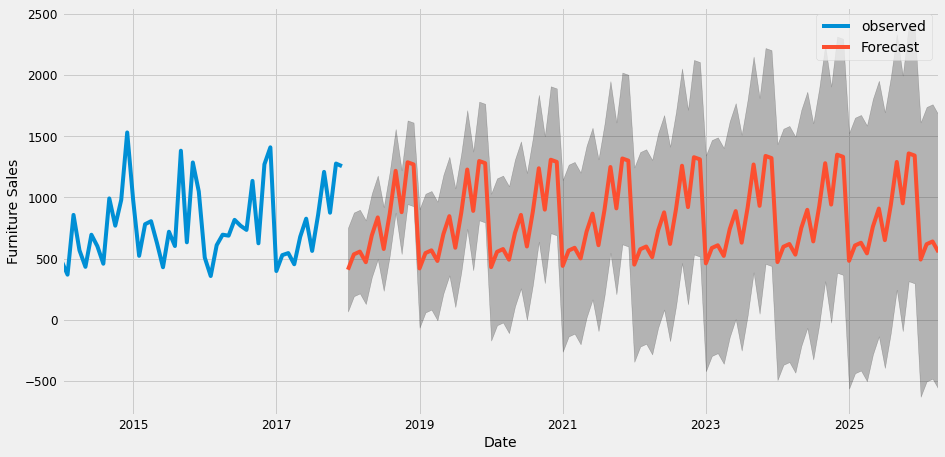

In [23]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# Comparing two trends (Furniture vs office supplies sale)

In [25]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [26]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


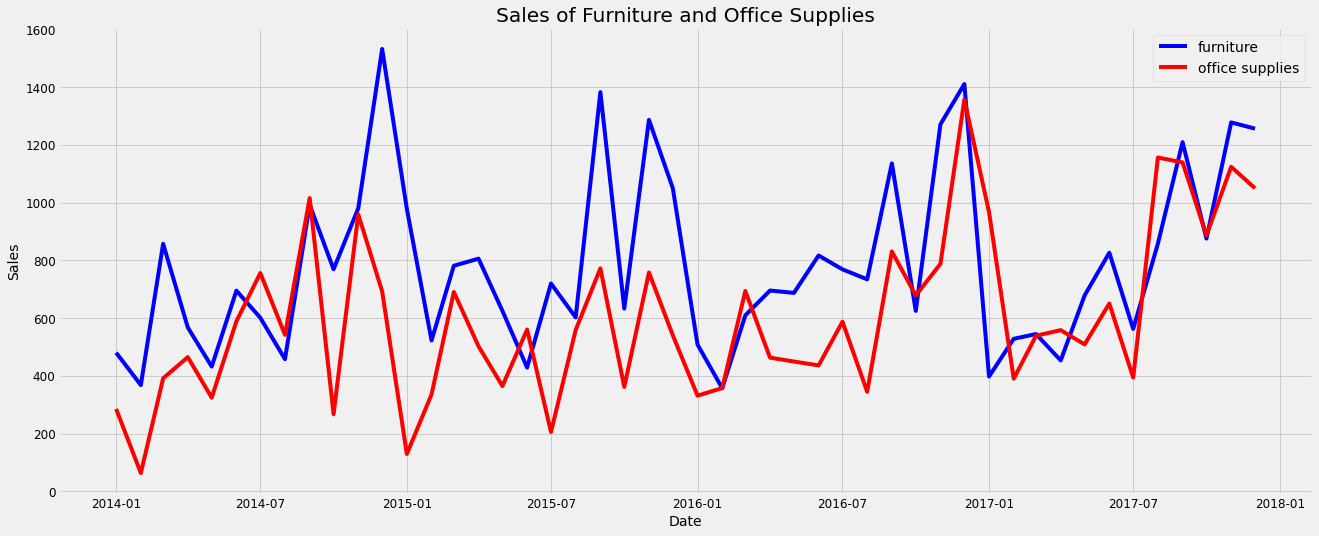

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

### Conclusion:
* Both sales start low at year start and rise at year end
* Average sales for furniture > avg sales for office supplies (either the no. of furniture sold is higher or price of furniture >> price of supplies)

### First time office supplies sales crossing furniture sales

In [33]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


# Trend analysis using prophet

In [39]:
from fbprophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

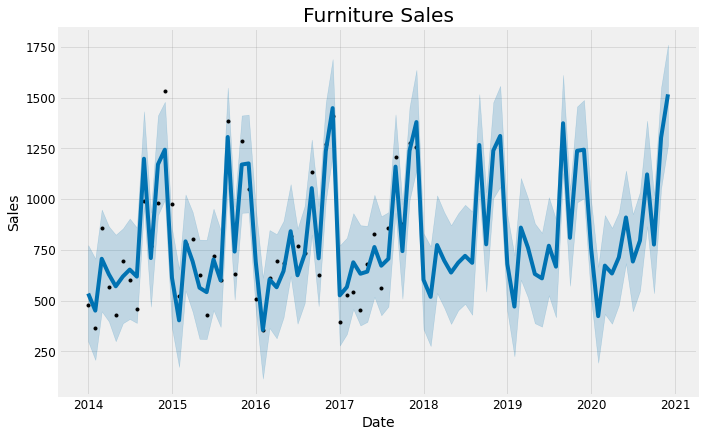

In [40]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

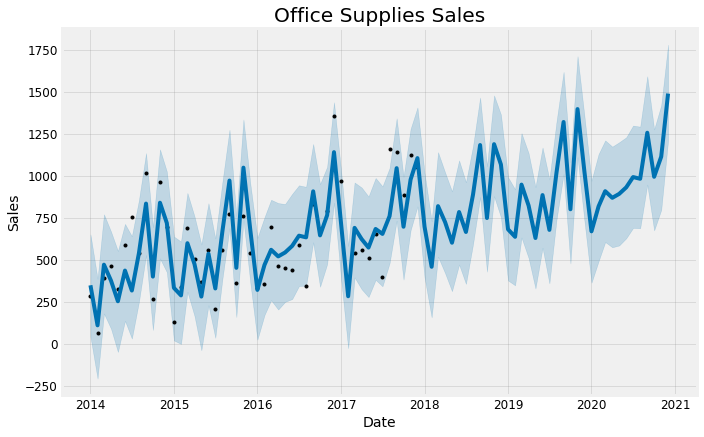

In [41]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

# Forecast

In [42]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)

forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,299.110465,773.433450,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,208.553601,707.057791,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,447.535541,948.563917,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,398.027484,865.628515,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,300.695525,824.788186,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


# compare forecasts

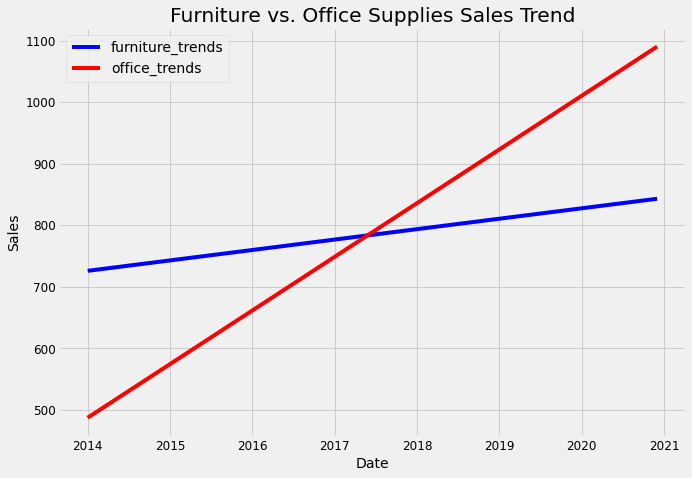

In [52]:
plt.figure(figsize=(10, 7))
furniture_graph = plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
office_graph = plt.plot(forecast['Date'], forecast['office_trend'], 'r-')

plt.legend(['furniture_trends','office_trends'])
plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

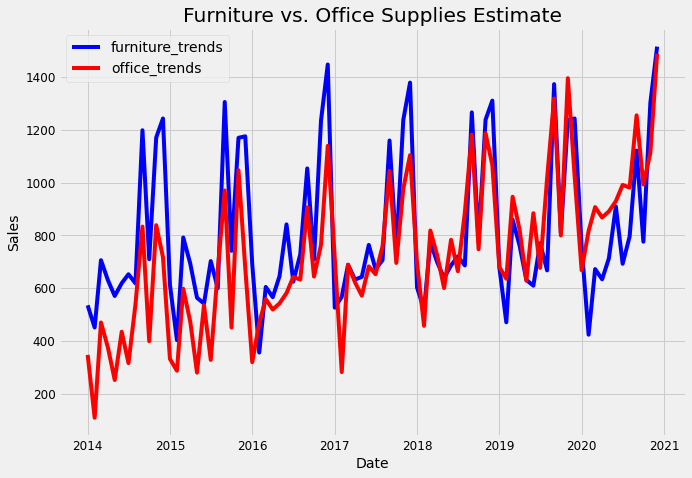

In [54]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(['furniture_trends','office_trends'])
plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

# Patterns

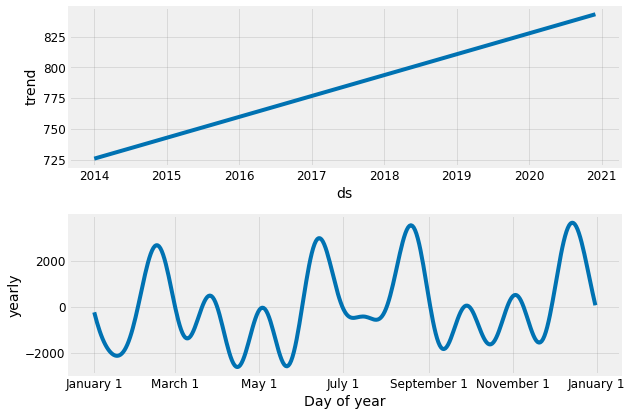

In [57]:
furniture_model.plot_components(furniture_forecast);

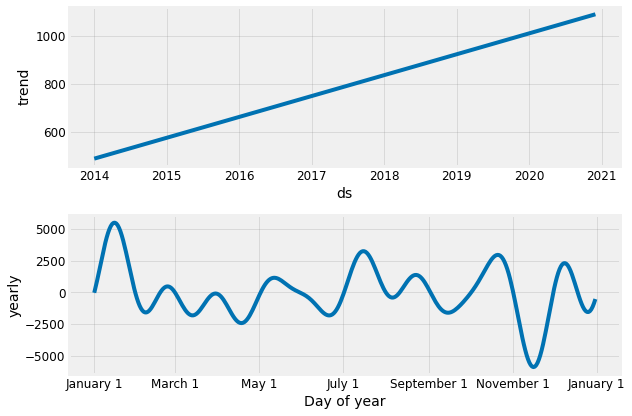

In [58]:
office_model.plot_components(office_forecast);